In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos desde los archivos CSV
payments = pd.read_csv("./project_dataset/extract-cash-request-data-analyst.csv")
fees = pd.read_csv("./project_dataset/extract-fees-data-analyst.csv")
# Convertir la columna de fechas a tipo datetime
payments['created_at'] = pd.to_datetime(payments['created_at'])
fees['created_at'] = pd.to_datetime(fees['created_at'])

# Extraer el año y el mes de la fecha de creación
payments['year_month'] = payments['created_at'].dt.to_period('M')
fees['year_month'] = fees['created_at'].dt.to_period('M')

# Encontrar la fecha de la primera operación para cada usuario por año y mes
first_operation = payments.groupby('user_id')['year_month'].min().reset_index()
first_operation.columns = ['user_id', 'first_operation_month']

# Unir esta información al DataFrame original de pagos
payments = pd.merge(payments, first_operation, on='user_id')

# Unir la información de la fecha de primera operación al DataFrame de fees usando cash_request_id
fees = pd.merge(fees, payments[['id', 'user_id', 'first_operation_month']], left_on='cash_request_id', right_on='id', how='left')


/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_74171/2990523420.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  payments['year_month'] = payments['created_at'].dt.to_period('M')
/var/folders/7c/3smlgk813_l8xy5r_2zy0trr0000gn/T/ipykernel_74171/2990523420.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fees['year_month'] = fees['created_at'].dt.to_period('M')


In [22]:
# Contar el número de operaciones por usuario por cohorte mensual
usage_frequency = payments.groupby(['first_operation_month', 'user_id']).size().reset_index(name='usage_count')

# Calcular la frecuencia media de uso por cohorte mensual
cohort_usage_frequency = usage_frequency.groupby('first_operation_month')['usage_count'].mean().reset_index()
cohort_usage_frequency.columns = ['cohort_month', 'avg_usage_frequency']

print(cohort_usage_frequency)



   cohort_month  avg_usage_frequency
0       2019-11             8.000000
1       2019-12             4.377451
2       2020-01             3.566667
3       2020-02             5.035714
4       2020-03             4.681159
5       2020-04             3.962264
6       2020-05             3.926829
7       2020-06             3.520927
8       2020-07             2.886399
9       2020-08             2.301829
10      2020-09             1.539720
11      2020-10             1.053046
12      2020-11             1.000000


In [23]:
# Contar el número de operaciones por usuario por cohorte mensual
usage_frequency = payments.groupby(['first_operation_month', 'user_id']).size().reset_index(name='usage_count')

# Calcular la frecuencia media de uso por cohorte mensual
cohort_usage_frequency = usage_frequency.groupby('first_operation_month')['usage_count'].mean().reset_index()
cohort_usage_frequency.columns = ['cohort_month', 'avg_usage_frequency']

print(cohort_usage_frequency)



   cohort_month  avg_usage_frequency
0       2019-11             8.000000
1       2019-12             4.377451
2       2020-01             3.566667
3       2020-02             5.035714
4       2020-03             4.681159
5       2020-04             3.962264
6       2020-05             3.926829
7       2020-06             3.520927
8       2020-07             2.886399
9       2020-08             2.301829
10      2020-09             1.539720
11      2020-10             1.053046
12      2020-11             1.000000


In [24]:
# Convertir la columna 'type' en una columna binaria 'incident' en el DataFrame 'fees'
fees['incident'] = fees['type'].apply(lambda x: 1 if x == 'incident' else 0)

# Calcular la tasa de incidentes por cohorte en el DataFrame 'fees'
incident_rate = fees.groupby('first_operation_month')['incident'].mean().reset_index()
incident_rate.columns = ['cohort_month', 'incident_rate']

print(incident_rate)



   cohort_month  incident_rate
0       2019-11       0.000000
1       2019-12       0.143345
2       2020-01       0.153285
3       2020-02       0.124352
4       2020-03       0.180124
5       2020-04       0.238901
6       2020-05       0.193182
7       2020-06       0.168439
8       2020-07       0.165547
9       2020-08       0.103571
10      2020-09       0.060298
11      2020-10       0.003967
12      2020-11       0.000000


In [29]:
# Calcular los ingresos totales por cohorte mensual
cohort_revenue = fees.groupby('first_operation_month')['total_amount'].sum().reset_index()
cohort_revenue.columns = ['cohort_month', 'total_revenue']

print(cohort_revenue)

   cohort_month  total_revenue
0       2019-11           50.0
1       2019-12         1465.0
2       2020-01          685.0
3       2020-02          965.0
4       2020-03          805.0
5       2020-04         2365.0
6       2020-05         5280.0
7       2020-06        20690.0
8       2020-07        16370.0
9       2020-08         7000.0
10      2020-09        15755.0
11      2020-10        28990.0
12      2020-11          335.0


In [26]:
# Calcular la tasa de retención de usuarios
def retention_rate(df, cohort, period):
    cohort_data = df[df['first_operation_month'] == cohort]
    active_users = cohort_data[cohort_data['year_month'] == period]['user_id'].nunique()
    total_users = cohort_data['user_id'].nunique()
    return active_users / total_users

# Calcular la tasa de retención para cada cohorte y periodo
retention = []
periods = payments['year_month'].unique()

for cohort in first_operation['first_operation_month'].unique():
    for period in periods:
        if period >= cohort:
            retention.append({
                'cohort_month': cohort,
                'period': period,
                'retention_rate': retention_rate(payments, cohort, period)
            })

retention_df = pd.DataFrame(retention)

# Verificar y convertir tipos de datos
retention_df['period'] = pd.to_datetime(retention_df['period'].astype(str), errors='coerce')
retention_df['retention_rate'] = pd.to_numeric(retention_df['retention_rate'], errors='coerce')

print(retention_df)

   cohort_month     period  retention_rate
0       2020-04 2020-04-01        1.000000
1       2020-04 2020-06-01        0.509434
2       2020-04 2020-07-01        0.396226
3       2020-04 2020-08-01        0.358491
4       2020-04 2020-10-01        0.278302
..          ...        ...             ...
86      2020-07 2020-08-01        0.499227
87      2020-07 2020-10-01        0.394900
88      2020-07 2020-09-01        0.374034
89      2020-07 2020-11-01        0.005410
90      2020-11 2020-11-01        1.000000

[91 rows x 3 columns]


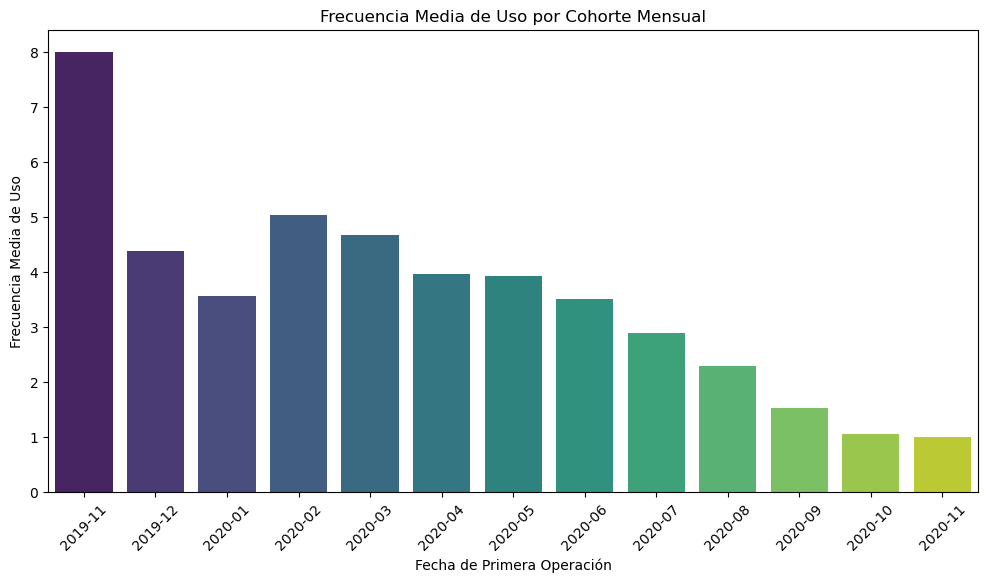

In [27]:
# Gráfico de barras para la frecuencia de uso
plt.figure(figsize=(12, 6))
sns.barplot(x='cohort_month', y='avg_usage_frequency', data=cohort_usage_frequency, palette='viridis')
plt.title('Frecuencia Media de Uso por Cohorte Mensual')
plt.xlabel('Fecha de Primera Operación')
plt.ylabel('Frecuencia Media de Uso')
plt.xticks(rotation=45)
plt.show()



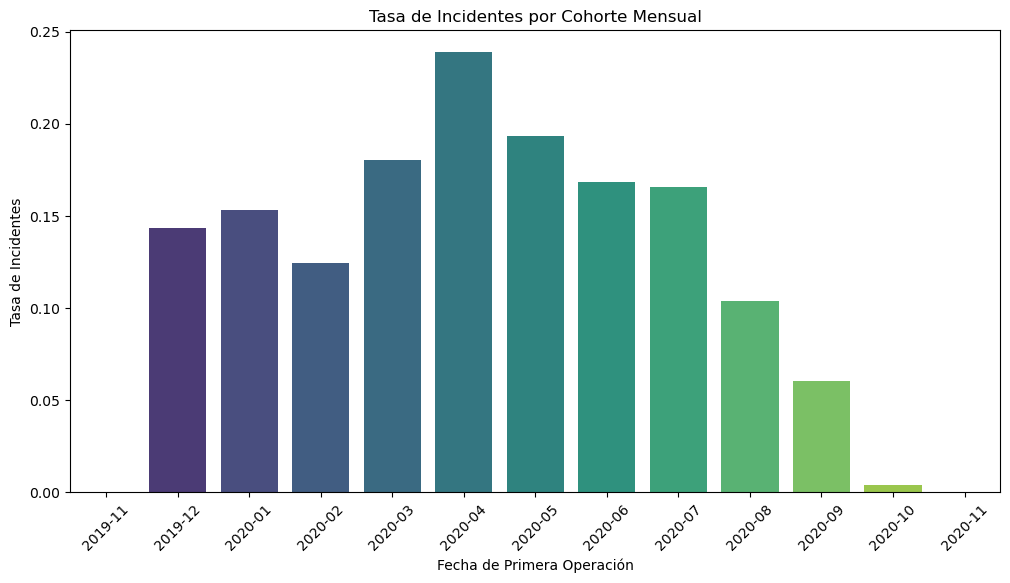

In [28]:
# Gráfico de barras para la tasa de incidentes
plt.figure(figsize=(12, 6))
sns.barplot(x='cohort_month', y='incident_rate', data=incident_rate, palette='viridis')
plt.title('Tasa de Incidentes por Cohorte Mensual')
plt.xlabel('Fecha de Primera Operación')
plt.ylabel('Tasa de Incidentes')
plt.xticks(rotation=45)
plt.show()



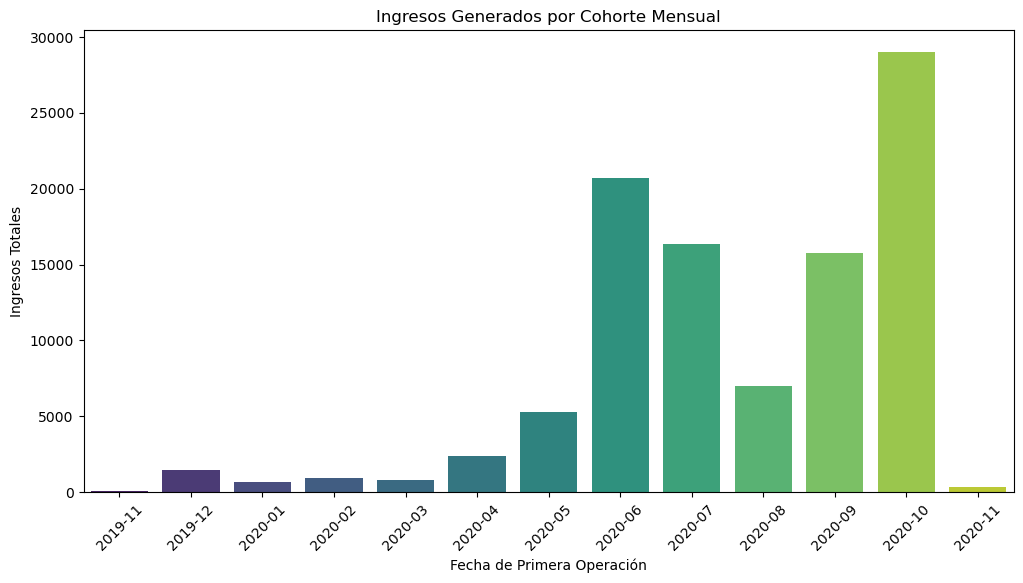

In [30]:
# Gráfico de barras para los ingresos generados
plt.figure(figsize=(12, 6))
sns.barplot(x='cohort_month', y='total_revenue', data=cohort_revenue, palette='viridis')
plt.title('Ingresos Generados por Cohorte Mensual')
plt.xlabel('Fecha de Primera Operación')
plt.ylabel('Ingresos Totales')
plt.xticks(rotation=45)
plt.show()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


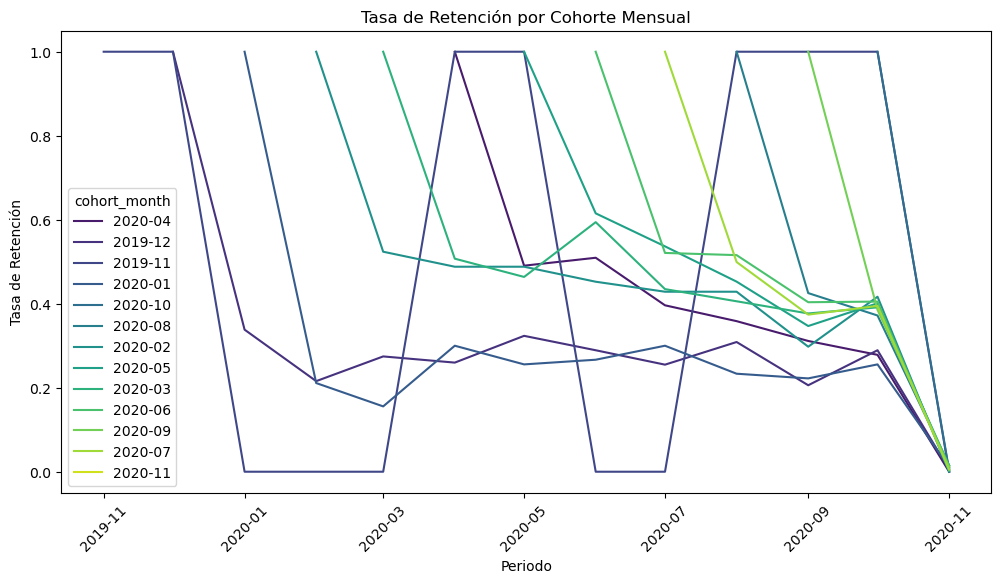

In [31]:
# Gráfico de línea para la tasa de retención
plt.figure(figsize=(12, 6))
sns.lineplot(x='period', y='retention_rate', hue='cohort_month', data=retention_df, palette='viridis')
plt.title('Tasa de Retención por Cohorte Mensual')
plt.xlabel('Periodo')
plt.ylabel('Tasa de Retención')
plt.xticks(rotation=45)
plt.show()

